## 3. Linear Regression


In [353]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from scipy import stats
from sklearn import datasets
from IPython.display import display, HTML
from sklearn.datasets import load_boston

# Q8. This question involves the use of simple linear regression on the Auto data set

In [18]:
auto = pd.read_csv('auto.csv')
auto= auto.drop(auto[auto.values=='?'].index).reset_index()
auto

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...,...
387,392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [19]:
# Convert quantitive datatypes to numerics
datatypes = {'quant': ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year'],
             'qual': ['origin', 'name']}

quants = auto[datatypes['quant']].astype(np.float_)

auto = pd.concat([quants, auto[datatypes['qual']]], axis=1)


In [20]:
auto['horsepower']

0      130.0
1      165.0
2      150.0
3      150.0
4      140.0
       ...  
387     86.0
388     52.0
389     84.0
390     79.0
391     82.0
Name: horsepower, Length: 392, dtype: float64

# (a) Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results. Comment on the output. For example:
    i. Is there a relationship between the predictor and the response?
    ii. How strong is the relationship between the predictor and the response?
    iii. Is the relationship between the predictor and the response positive or negative?
    iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [21]:
# Let's start by implementing linear regression from scratch
# using numpy linear algebra

# 
intersect = pd.DataFrame({'B0': np.ones(auto.shape[0])})

X = pd.concat([intersect,auto['horsepower']],axis=1)
y= auto['mpg']

def linear_function(X,y):
    XTX_inv = np.linalg.inv(X.T @ X)
    XTy = X.T @ y
    beta = XTX_inv @ XTy
    return beta

def pred(beta,X):
    """"predict""" 
    return  X @ beta


In [22]:
beta = linear_function(X,y)
y_pred = pred(beta,X)
# Calculate MSE error
MSE = np.sum(np.square(y-y_pred)) / y.size
#Variance of each variable in X
var =  MSE * (np.linalg.inv(X.T @ X).diagonal())
# standard error
std = np.sqrt(var)
# t -statistic = b-0 / se(b)
t_statistic = beta / std
# p-values
p_values = 2*(1 - stats.t.cdf(X.shape[0], np.abs(t_statistic)))

# present results
results = pd.DataFrame({'features': X.columns,'coefficients':beta,'MSE': MSE, 'Standard deviation': std,
                       't-statistics':t_statistic,'p-values > t':p_values}).set_index('features')
results

,coefficients,MSE,Standard deviation,t-statistics,p-values > t
features,,,,,
B0,39.935861,23.943663,0.715666,55.802376,0.0
horsepower,-0.157845,23.943663,0.006429,-24.551848,0.0


In [23]:
# Alternative with stats.model

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 03 May 2020   Prob (F-statistic):           7.03e-81
Time:                        20:20:55   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B0            39.9359      0.717     55.660      0.0

i. Is there a relationship between the predictor and the response?
    
    Yes, the low P-value associated with the t-statistic for horsepower suggests so.

ii. How strong is the relationship between the predictor and the response?
        
    For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg.

iii. Is the relationship between the predictor and the response positive or negative?
    
    Negative
    
iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals?

In [24]:
X_ex = np.array([1, 98])

y_ex = beta.T @ X_ex
print(str(np.round(y_ex, 3)) + ' mpg')

24.467 mpg


In [25]:
# the associated 95% confidence and prediction intervals
model_min = results.conf_int(alpha=0.05)[0]
model_max = results.conf_int(alpha=0.05)[1]

confidence_interval = [model_min.T @ X_ex , model_max.T @ X_ex]

print(confidence_interval)

[21.814544959722646, 27.119609345302205]


# (b) Plot the response and the predictor. Use the abline() function to display the least squares regression line

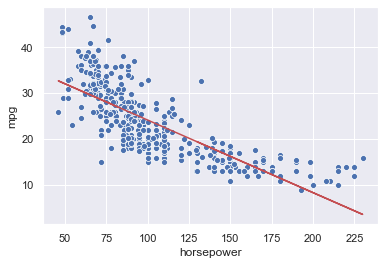

In [26]:
df = pd.concat([auto['horsepower'],auto['mpg']],axis=1)
ax = sns.scatterplot(x='horsepower',y='mpg',data = df)
ax.plot(auto['horsepower'], y_pred,color='r')

In [27]:
# residuals, H hat, leverage, external variance , external t-studentized

def lm_stats(X,y,y_pred):
    
    try:
        y.shape[1]==1
        y=y.iloc[:,0]
    except:
        pass
    y = np.array(y)
    
    #residuals
    residuals = np.array(y-y_pred)
    
    # Hat matrix
    H = np.array(np.array(X @ np.linalg.inv(X.T @ X)) @ X.T)
    print()
    # Leverage
    h_ii = H.diagonal()
    
    #external variance
    o_ii = []
    for i in range(X.shape[0]):
        external_res = np.delete(residuals,i)
        o_ii += [np.sqrt( (1 / (X.shape[0]-X.shape[1]-1))  * np.sum(np.square(external_res)))]
    oext = np.array(o_ii)
    
    # external t-studentized
    t_studentized = residuals / (oext * np.sqrt(1-h_ii))
    
    return pd.DataFrame({'residual':residuals,'leverage':h_ii,'t':t_studentized,'y_pred':y_pred})

def lm_plot(lm_stats_df):
    # Parse stats
    t      = lm_stats_df['t']
    h_ii   = lm_stats_df['leverage']
    y_pred = lm_stats_df['y_pred']
    
    
    # figure
    plt.figure(1, figsize=(16, 18))
    ## Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual plot', fontweight='bold')
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color='r', linestyle='dashed')
    ax.axhline(y=-3, color='r', linestyle='dashed');
    
    #Normal Q-Q plot -> indicates which distribution match our dataset, 
    #shows were the dots showing where the quantiles from our data set intersect from the quantiles of the normal distribution 
    # if the dots are on the line, it means that both our data and the distribution have comparable quantiles
    plt.subplot(322)
    ax = stats.probplot(t, dist='norm', plot=plt)
    plt.title('Normal Q-Q', fontweight='bold')
    plt.ylabel('Studentised residuals')

    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel('Fitted values')
    plt.ylabel('√Standardized residuals')
    plt.title('Scale-Location', fontweight='bold')
    
    #Residuals vs Leverage
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii,y=t)
    plt.xlabel('Leverage')
    plt.ylabel('Studentised residuals')
    plt.title('Externally studentised residual vs Leverage', fontweight='bold');
    

In [28]:
lm_stats(X,y,y_pred)

,residual,leverage,t,y_pred
0,-1.416046,0.003676,-0.288842,19.416046
1,1.108520,0.008876,0.226696,13.891480
2,1.740849,0.006130,0.355552,16.259151
3,-0.259151,0.006130,-0.052921,16.259151
4,-0.837598,0.004730,-0.170930,17.837598
...,...,...,...,...
387,0.638786,0.003140,0.130252,26.361214
388,12.272065,0.007303,2.527891,31.727935
389,5.323097,0.003274,1.087100,26.676903
390,0.533873,0.003671,0.108888,27.466127


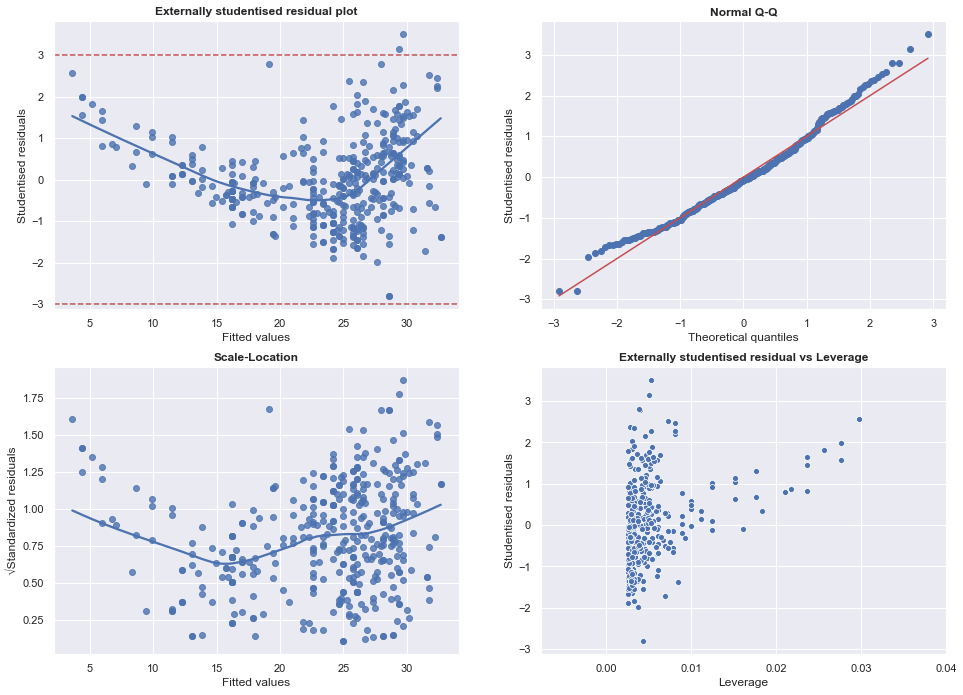

In [29]:
lm_plot(lm_stats(X,y,y_pred))

The above residual plot grid shows the relationship between the horsepower predictor and the mpg response. There are several things to note:

Non-linearity of the data: 

    The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.

Heteroscedasticity – Non-constant variance of error terms 

    The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.
    
Outliers and leverage: 

    the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.
    
The top-right plot shows that our studentised residuals have a slightly non-normal distribution. It shows where the quantiles from our data set intersect from the quantiles of the normal distribution. Since the dots, are not on the regression line, it means that both our data and the distribution do not have comparable quantiles. Perhaps a different distribution would fit the data better.

In [30]:
def lm_correlation_of_error_terms(dataframe):
    residuals = dataframe['residual']
    plt.figure(1,figsize=(15,5))
    ax = sns.lineplot(x=np.arange(1,residuals.shape[0]+1),y=residuals,marker="o")
    ax.axhline(y=0,color='r', linestyle='-.')
    plt.title('Residual plot from observation data')
    plt.xlabel('Observations')
    plt.ylabel('Residual')
    

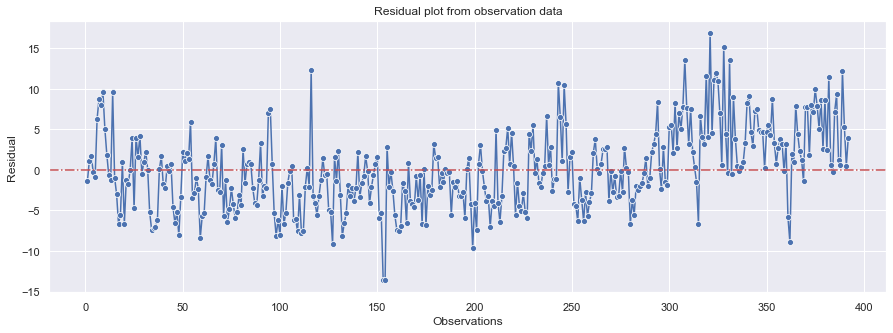

In [31]:
lm_correlation_of_error_terms(lm_stats(X,y,y_pred))

- Correlation of error terms: 

    The Correlation of Error Terms plot shows errors against ordered observations in our dataset. We see a slight increase in error above the 300th observation suggesting some correlation effect. Also, one can see some tracking effects: adjacent points having similar residual values. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.

# 9. This question involves the use of multiple linear regression on the Auto data set.
    (a) Produce a scatterplot matrix which includes all of the variables in the data set

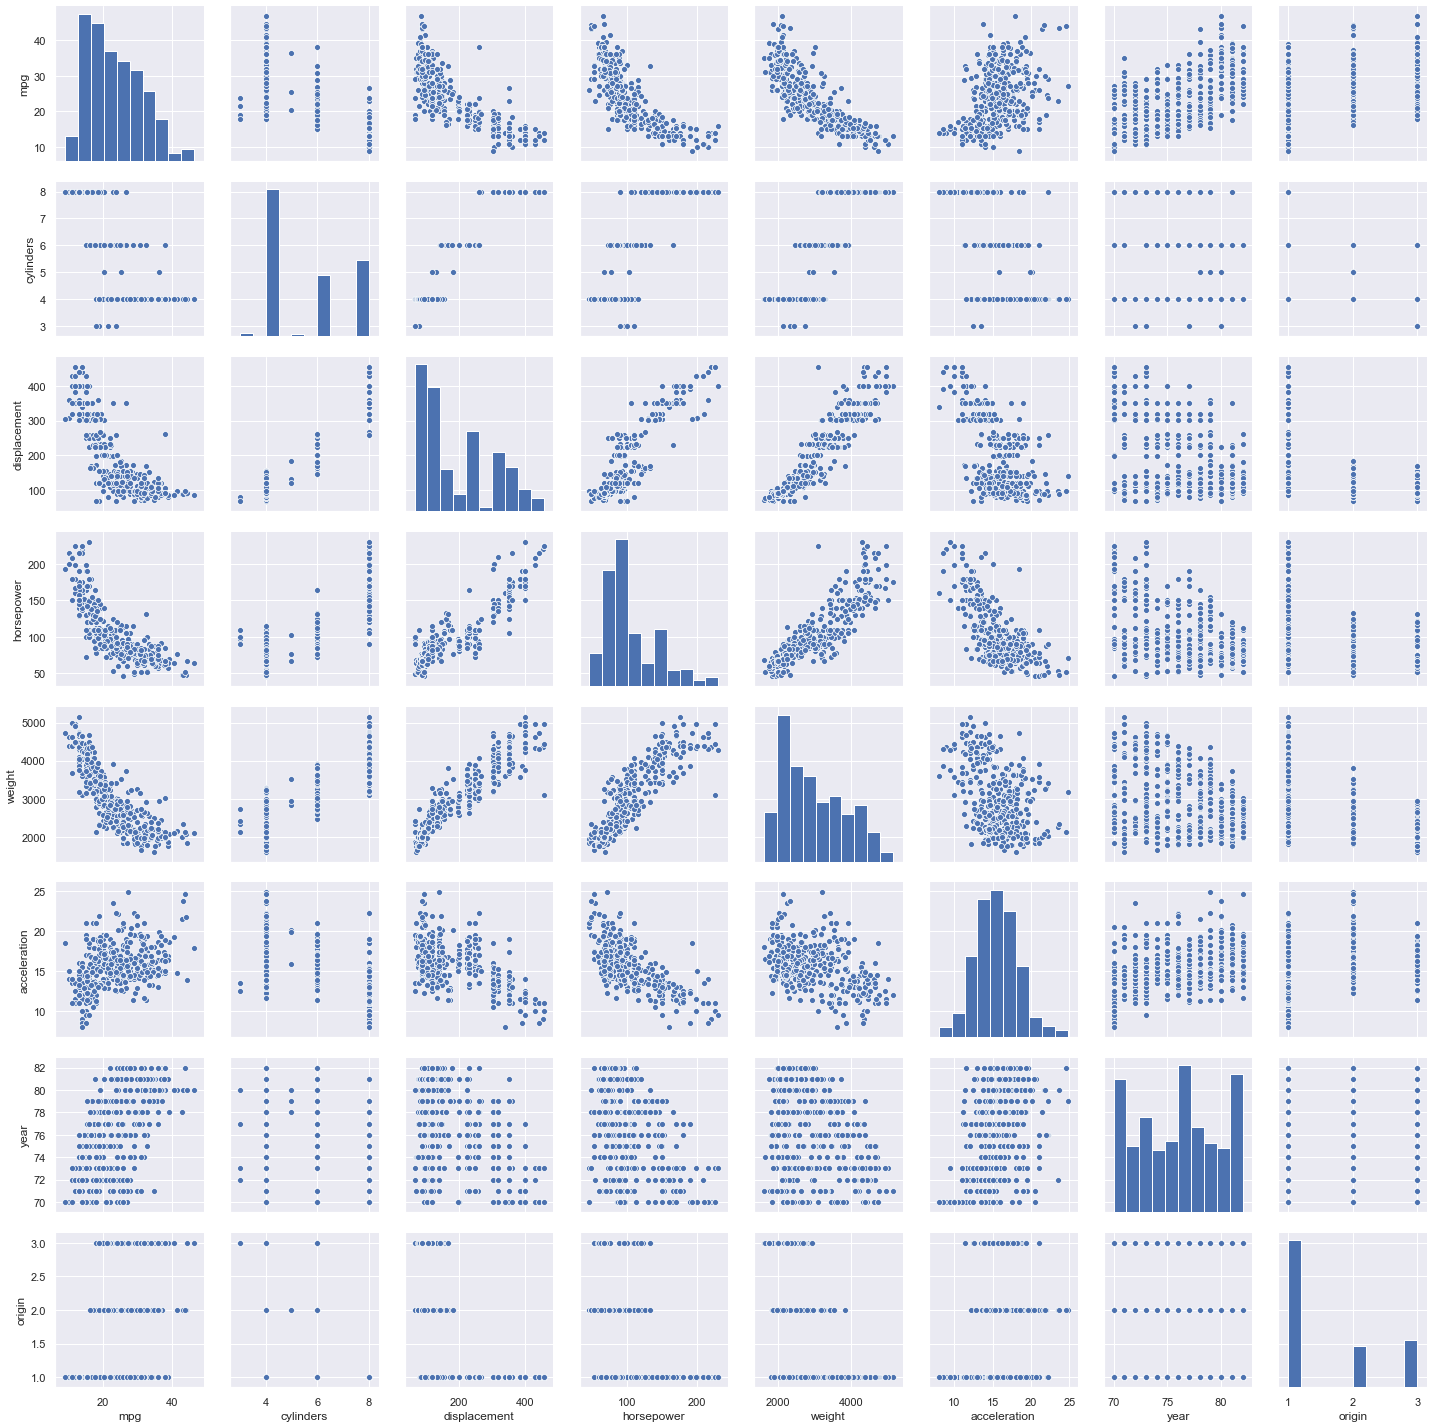

In [32]:
sns.pairplot(auto)

b) Compute the matrix of correlations between the variables using the function cor(). You will need to exclude the name variable, which is qualitative

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text yticklabel objects>)

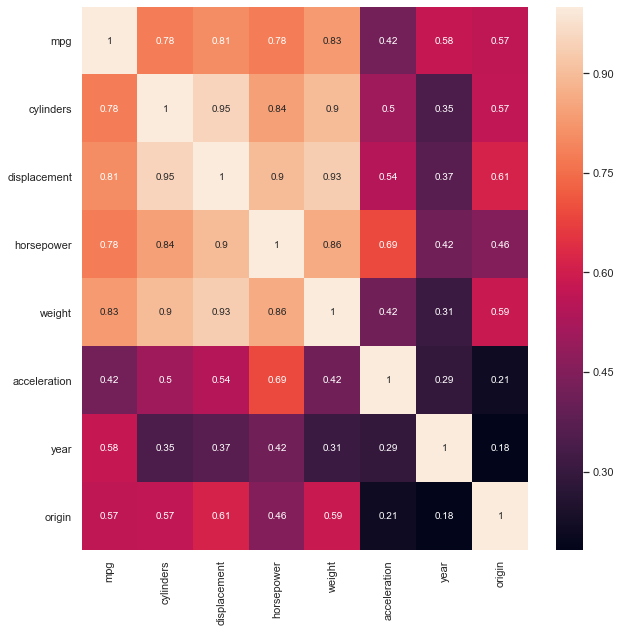

In [33]:
auto_excl = auto.drop(['name'],axis=1)
auto_excl.corr().abs()
plt.figure(figsize=(10,10))
sns.heatmap(auto_excl.corr().abs(),annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

(c) Perform a multiple linear regression with mpg as the response and all other variables except name as the predictors. Use the summary() function to print the results. Comment on the output. For instance:

    Is there a relationship between the predictors and the response?
    Which predictors appear to have a statistically significant relationship to the response?
    What does the coefficient for the year variable suggest?
    

In [39]:
f = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = patsy.dmatrices(f, auto, return_type='dataframe')

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 03 May 2020   Prob (F-statistic):          1.79e-139
Time:                        20:22:16   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.9546      4.677     -3.

In [ ]:
#auto = auto.drop(['name'],axis=1)
origin = pd.get_dummies(auto,prefix=['origin'],columns=['origin'],drop_first=True)
intersect = pd.DataFrame({'BO': np.ones(auto.shape[0])})
auto_new  = pd.concat([intersect,origin],axis=1).drop(['mpg'],axis=1)




In [38]:
#auto_new = auto_new.drop(['BO'],axis=1)
#auto_new = auto_new.drop(['name'],axis=1)
auto_new
model = sm.OLS(y,auto_new).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     224.5
Date:                Sun, 03 May 2020   Prob (F-statistic):          1.79e-139
Time:                        20:22:03   Log-Likelihood:                -1020.5
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     383   BIC:                             2095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
BO             -17.9546      4.677     -3.839   

In [40]:
#The following predictors have P-values < 0.05 which suggests we can reject 
# the null hypothesis that they have no relationship with the response:
model.pvalues[model.pvalues < 0.05].sort_values()

year              2.332943e-40
weight            6.375633e-22
C(origin)[T.3]    3.933208e-07
C(origin)[T.2]    4.720373e-06
Intercept         1.445124e-04
displacement      1.862685e-03
dtype: float64

The coefficient for the year variable suggests that there is a positive relationship between year and mpg – the response variable increases as year increases. Specifically, this suggessts that cars manufactured more recently tend to be more fuel efficient and that all else being equal efficiency increases by 0.77 mpg/year.

# d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

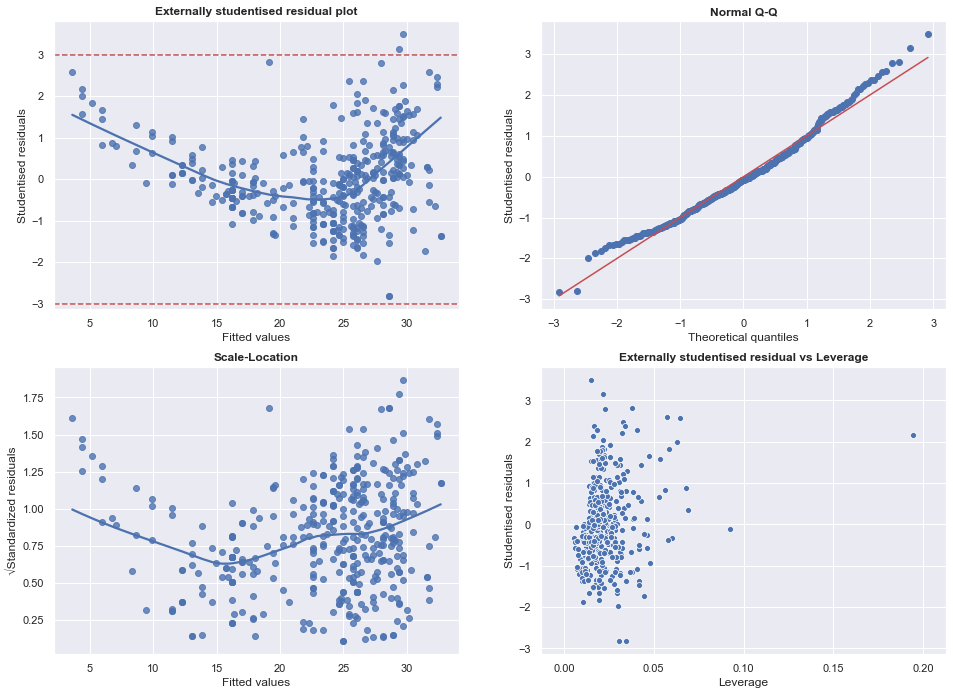

In [43]:
lm_plot(lm_stats(auto_new,y,y_pred))





- Linearity: The u-shaped pattern in the top-left residual plot suggests that there a non-linear relationship that our model is unable to account for. The bottom left Scale-Location plot suggests that a square-root transform reduces the non-linearity of this relationship allowing our model to achieve an improved fit.

- Heteroscedasticity: A conical pattern is apparent in the top-left plot suggesting that variance of residuals increases with response. The bottom left plot suggests that a square-root transform helps to mitigate this effect.

- Outliers: The top-left plot suggests that there are five potential outliers towards the high end of our predicted responses. The bottom-right plot suggests that these outliers have low leverage, and so probably don't have a overly dispraportionate effect on our model.

- Leverage: The bottom right plot reveals one point with particularly high leverage, although with a value around -1.2 this point isn't an outlier in terms of studentised residuals.

- Normality: The top-right plot shows a normal distribution except for high value residuals. This suggests that the model under-estimates mpg for a larger number of observations than we might expect assuming a normal distribution.

In [57]:
f = 'np.log1p(mpg) ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin) \
    + cylinders*displacement \
    + cylinders*horsepower \
    + cylinders*weight \
    + cylinders*acceleration \
    + cylinders*year \
    + displacement*horsepower \
    + displacement*weight \
    + displacement*acceleration \
    + displacement*year \
    + horsepower*weight \
    + horsepower*acceleration \
    + horsepower*year \
    + weight*weight \
    + weight*acceleration \
    + weight*year \
    + acceleration*year \
    '

y, X = patsy.dmatrices(f, auto, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     152.3
Date:                Sun, 03 May 2020   Prob (F-statistic):          2.31e-172
Time:                        22:40:32   Log-Likelihood:                 346.65
No. Observations:                 392   AIC:                            -645.3
Df Residuals:                     368   BIC:                            -550.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [61]:
# p values less than 0.05 <- reject the null hypothesis
model.pvalues[model.pvalues<0.05].sort_values()

cylinders:displacement    0.009575
acceleration              0.009944
acceleration:year         0.011091
displacement:year         0.017965
Intercept                 0.048352
dtype: float64

Only the above features seem to be statistically significant in this model.

Notice the warning (2) that suggests there might be multicollinearity in this model. We can observe in the correlation plot above that there is strong collinearity between mpg, cylinders, displacement, horespower, and weight. This means further investigation is required to discern which, if any, of these features have a causal relationship with our response mpg.

**(f) Try a few different transformations of the variables, such as log(X), √X, X2. Comment on your findings.**

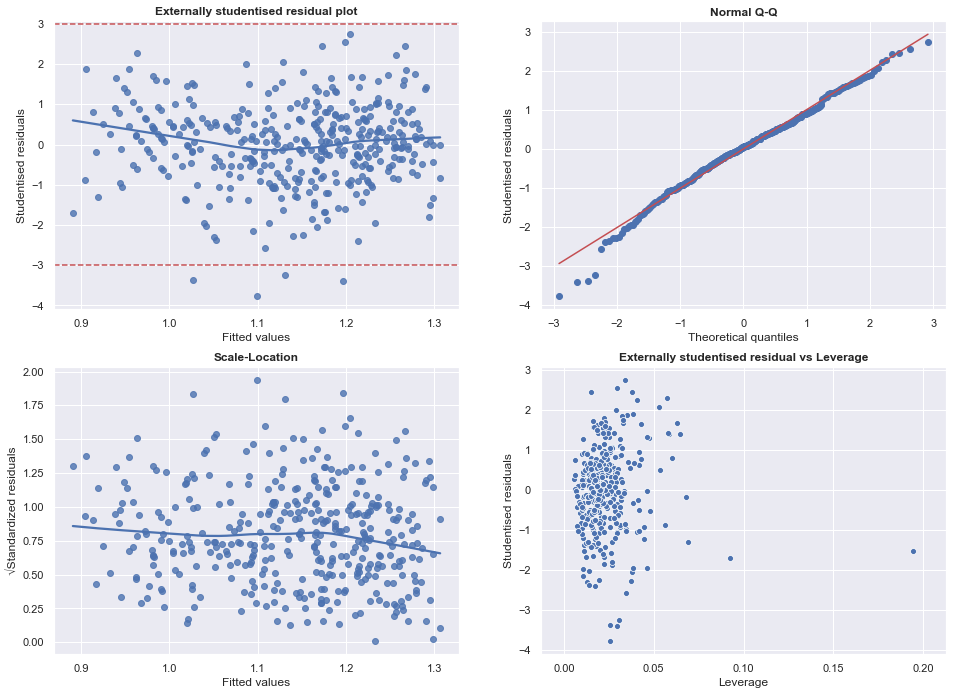

In [70]:
# log of the response first
log_y= np.log(y)

log_response = sm.OLS(log_y,auto_new).fit()
y_pred_log = log_response.predict(auto_new)
lm_plot(lm_stats(auto_new,log_y,y_pred_log))

**Comment: Taking the log of the response variable dramatically improves aspects of our diagnostic plots.**

- there is less pattern in the left-hand residual plots suggesting the log transform of mpg as decreased the non-linearity of its relationship to features and so improved our models ability to fit the date.

- there is a reduction in the conic shape of the bottom left plot suggesting a reduction in homoscedasticity.

- the top-right plot suggests the model is now inclined to overstimate instead of underestimate
- there are no-longer any outliers exceeding a studentised residual value of three. there are now four outliers <-3

**Question: What if we take logs of all our predictor variables also?**

In [72]:
f = 'np.log1p(mpg) \
    ~ np.log1p(cylinders) \
    + np.log1p(displacement) \
    + np.log1p(horsepower) \
    + np.log1p(weight) \
    + np.log1p(acceleration) \
    + np.log1p(year) \
    + C(origin) \
    + np.log1p(cylinders*displacement) \
    + np.log1p(cylinders*horsepower) \
    + np.log1p(cylinders*weight) \
    + np.log1p(cylinders*acceleration) \
    + np.log1p(cylinders*year) \
    + np.log1p(displacement*horsepower) \
    + np.log1p(displacement*weight) \
    + np.log1p(displacement*acceleration) \
    + np.log1p(displacement*year) \
    + np.log1p(horsepower*weight) \
    + np.log1p(horsepower*acceleration) \
    + np.log1p(horsepower*year) \
    + np.log1p(weight*weight) \
    + np.log1p(weight*acceleration) \
    + np.log1p(weight*year) \
    + np.log1p(acceleration*year) \
    '
    
y,X = patsy.dmatrices(f,auto,return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          np.log1p(mpg)   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     166.0
Date:                Sun, 03 May 2020   Prob (F-statistic):          9.11e-181
Time:                        23:10:16   Log-Likelihood:                 370.15
No. Observations:                 392   AIC:                            -690.3
Df Residuals:                     367   BIC:                            -591.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [73]:
model.pvalues[model.pvalues<0.05].sort_values()

np.log1p(cylinders * displacement)     5.450938e-07
np.log1p(year)                         3.554276e-06
Intercept                              4.103286e-06
np.log1p(horsepower * acceleration)    4.088496e-04
np.log1p(cylinders * acceleration)     5.328883e-03
np.log1p(horsepower * weight)          1.089279e-02
np.log1p(horsepower * year)            2.345207e-02
np.log1p(displacement)                 3.208041e-02
np.log1p(cylinders * horsepower)       4.141974e-02
dtype: float64

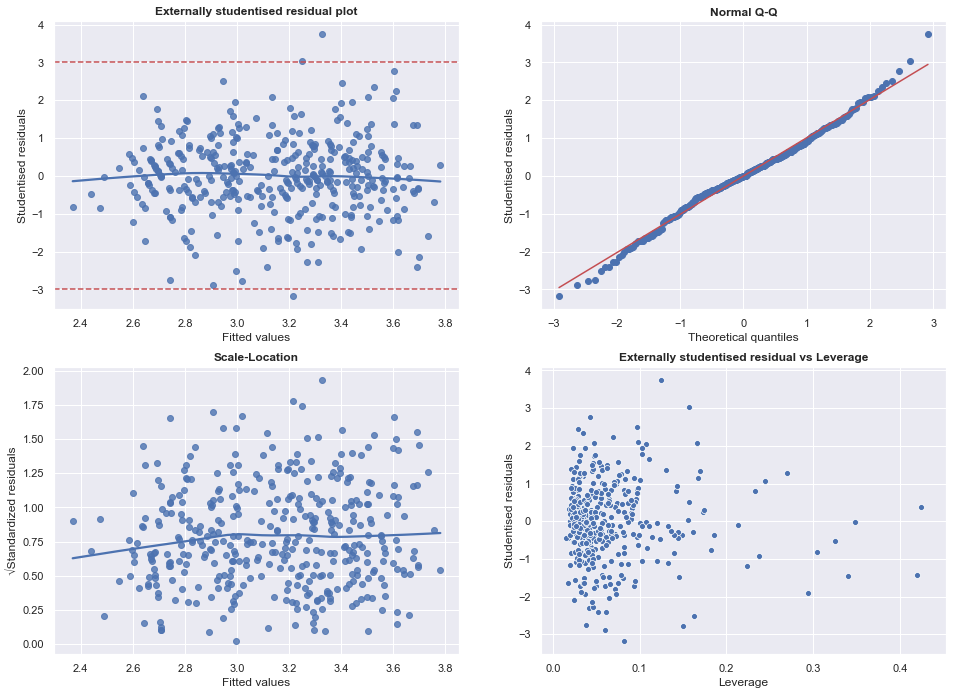

In [75]:
y_pred = model.predict(X)
lm_plot(lm_stats(X,y,y_pred))

**Comment: Comparing the above diagnostics grid with the preceding grid suggests that taking log of predictors has further reduced the non-linearities in our dataset.**

The number of observations that appear as outliers has reduced from four to two. Heteroscedasticity has also been reduced. The distribtuion of studentised residuals is more normal.

There is notably increased variance in the leverage of our observations

**Question: what if we only use the features from this model with p-values < 0.05?**

In [85]:
significant_features = model.pvalues[model.pvalues < 0.05].drop('Intercept').index
f = 'np.log(mpg) ~ ' + ' + '.join(list(significant_features))

y, X = patsy.dmatrices(f,auto,return_type='dataframe')
model = sm.OLS(y,X).fit()
results = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            np.log(mpg)   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     525.1
Date:                Sun, 03 May 2020   Prob (F-statistic):          6.31e-182
Time:                        23:26:57   Log-Likelihood:                 301.73
No. Observations:                 392   AIC:                            -589.5
Df Residuals:                     385   BIC:                            -561.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

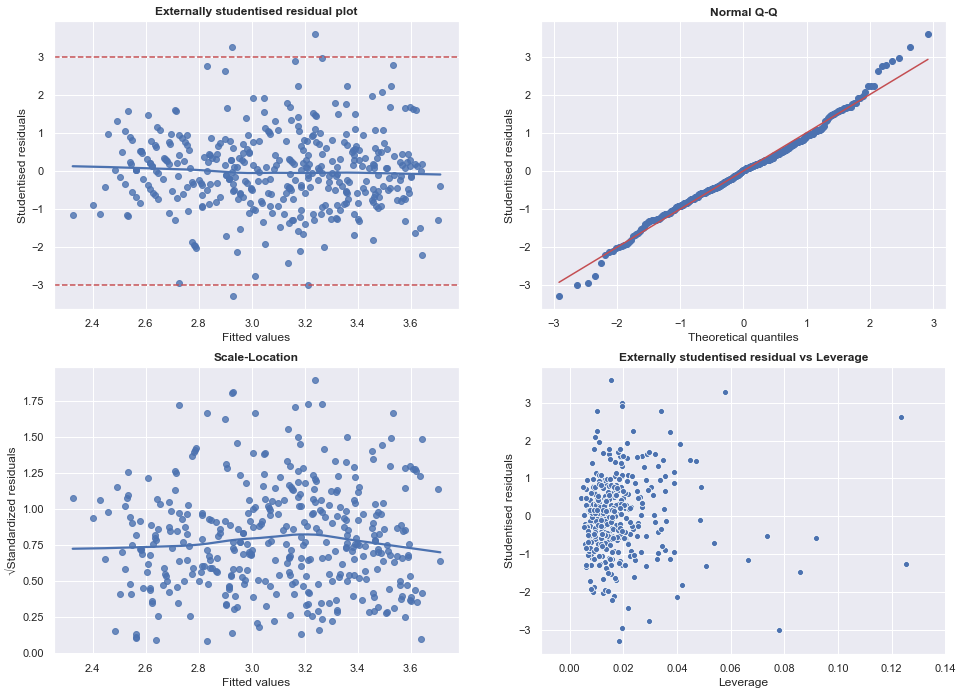

In [86]:
lm_plot(lm_stats(X,y,results))

- The top-left plot suggests that our model is now fitting the data with even less loss. There is no notable heteroscedasticity, and the distribution of the residuals appears normal.

- The variance in leverage of observations is reduced and there are three potential outliers.

- In the top-left residual plot there is a repeating linear pattern for Fitted values < 2.8. This pattern is not visible in the plot below.

### 10. This question should be answered using the Carseats data set.

**(a) Fit a multiple regression model to predict Sales using Price, Urban, and US**

In [118]:
car = pd.read_csv('Carseats_training.csv')
Urban = pd.get_dummies(car['Urban'],prefix='Urban',drop_first=True)
US = pd.get_dummies(car['US'],prefix='US',drop_first=True)
Price = car['Price']
#intersect = pd.DataFrame({'Bo':np.ones(car.shape[0])})
car

,ID,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,1,10.48,138,72,0,148,94,Medium,27,17,Yes,Yes
1,2,10.43,77,69,0,25,24,Medium,50,18,Yes,No
2,3,5.32,118,74,6,426,102,Medium,80,18,Yes,Yes
3,4,7.67,129,117,8,400,101,Bad,36,10,Yes,Yes
4,5,5.32,152,116,0,170,160,Medium,39,16,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,6.71,119,67,17,151,137,Medium,55,11,Yes,Yes
316,317,5.28,108,77,13,388,110,Bad,74,14,Yes,Yes
317,318,6.52,128,42,0,436,118,Medium,80,11,Yes,No
318,319,11.62,151,83,4,325,139,Good,28,17,Yes,Yes


In [124]:
car_model = pd.concat([intersect,Price,Urban,US],axis=1)
y = car['Sales']

model = sm.OLS(y,car_model).fit()
y_pred = model.predict(car_model)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     32.80
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.75e-18
Time:                        10:31:44   Log-Likelihood:                -742.50
No. Observations:                 320   AIC:                             1493.
Df Residuals:                     316   BIC:                             1508.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Bo            12.9436      0.737     17.573      0.0

**b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative**

- Sales decrease with increase in Price. For each unit increase in Price, Sales decrease by 0.0536 * 1000 = 53.6 dollars on average.
- There seems to be a statistically significant relationship between Sales and whether the store is in the U.S. or not. We expect carseats sold in the US to achieve a salprice 1,241 dollars higher on average.
- There does not seem to be significant relationship between Sales and wheter the store is in an urban or rural relationship

**(c) Write out the model in equation form, being careful to handle the qualitative variables properly.**

**ŷ =12.9436+(−0.0214×Urban)+(1.2411×US)+(−0.0536×Price)**

Where Urban and US are encoded as dummy variables:

- Urban: Yes => 1
- Urban:No => 0
- US: Yes => 1
- US: No => 0

**(d) For which of the predictors can you reject the null hypothesis H0 :βj =0?**

- Price and US stores

**(e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.**

In [126]:
small_model = pd.concat([intersect,US,Price],axis=1)

model2 = sm.OLS(y,small_model).fit()
y_pred2 = model2.predict(small_model)
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     49.36
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.18e-19
Time:                        10:33:19   Log-Likelihood:                -742.50
No. Observations:                 320   AIC:                             1491.
Df Residuals:                     317   BIC:                             1502.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Bo            12.9300      0.709     18.234      0.0

**(f) How well do the models in (a) and (e) fit the data?**

- model (a)

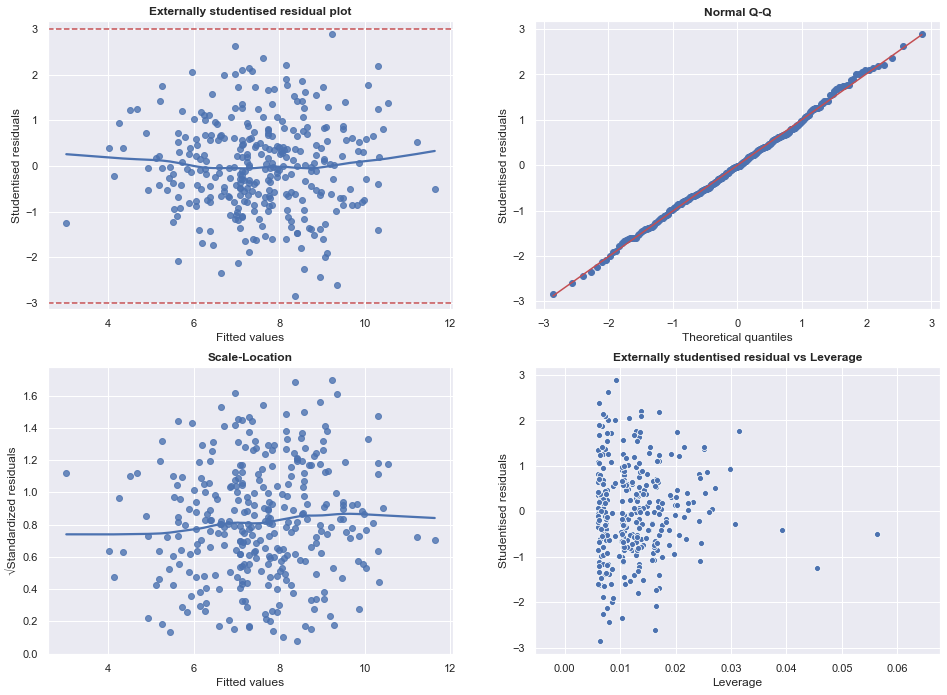

In [125]:
lm_plot(lm_stats(car_model,y,y_pred))

- model (e)

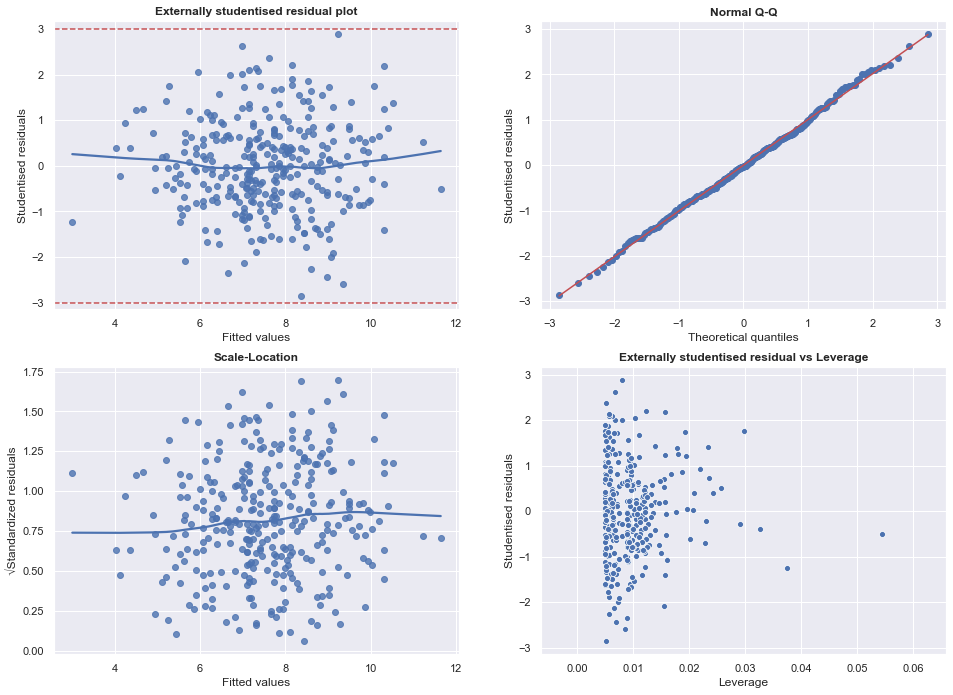

In [127]:
lm_plot(lm_stats(small_model,y,y_pred2))

Comment: The diagnostic plots above illustrate the fit of our model. The top-left plot shows only subtle discernible pattern suggesting our linear model has achieved a reasonable fit to the data. The distribution of residuals appears normal and there is no heteroscedasticity.

**(g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).**

In [131]:
conf_interval_95 =  model2.conf_int(alpha=0.05)
conf_interval_95.rename(index=str, columns={0: "min.", 1: "max.",})

,min.,max.
Bo,11.534851,14.325179
US_Yes,0.671733,1.809160
Price,-0.065221,-0.042056


**(h) Is there evidence of outliers or high leverage observations in the model from (e)?**

- No observations exceed the studentised residual thresholds for outliers of +/-3, although a couple come close.

- There is one observation that stands out as particularly high leverage in the bottom-right plot above, but this observation is not an outlier.

# 11. In this problem we will investigate the t-statistic for the null hypothesis H0 : β = 0 in simple linear regression without an intercept. To begin, we generate a predictor x and a response y as follows.

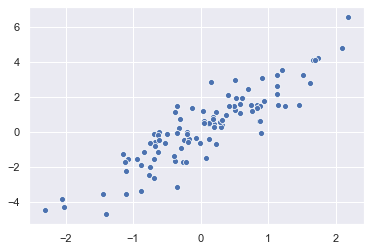

In [132]:
np.random.seed(1)
x  = np.random.normal(size=100)
y  = 2*x + np.random.normal(size=100)
df = pd.DataFrame({'x': x, 'y': y}) 
sns.scatterplot(x=x, y=y, color='b');

**(a) Perform a simple linear regression of y onto x, without an intercept. Report the coefficient estimate βˆ, the standard error of this coefficient estimate, and the t-statistic and p-value associated with the null hypothesis H0 : β = 0. Comment on these results. (You can perform regression without an intercept using the command lm(y∼x+0).)**

In [146]:
y = df['y']
x= df['x']


model3 = sm.OLS(y,x).fit()
print(model3.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Mon, 04 May 2020   Prob (F-statistic):                    3.46e-36
Time:                        11:14:31   Log-Likelihood:                         -135.67
No. Observations:                 100   AIC:                                      273.3
Df Residuals:                      99   BIC:                                      275.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

- Our model estimates the coefficient of x as 2.1067 which is a slight overestimate of the known true value of 2.0, however the 95% confidence bounds do include the true value of x.

- Our model suggests that there is a significant relationship between x and y.

**(b) Now perform a simple linear regression of x onto y without an intercept, and report the coefficient estimate, its standard error, and the corresponding t-statistic and p-values associated with the null hypothesis H0 : β = 0. Comment on these results.**

In [147]:
model4 = sm.OLS(x,y).fit()
print(model4.summary())

                                 OLS Regression Results                                
Dep. Variable:                      x   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.796
Method:                 Least Squares   F-statistic:                              391.7
Date:                Mon, 04 May 2020   Prob (F-statistic):                    3.46e-36
Time:                        11:16:52   Log-Likelihood:                         -49.891
No. Observations:                 100   AIC:                                      101.8
Df Residuals:                      99   BIC:                                      104.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We know that y increases by 0.5 for every unit increase in x. Our model understimates this coefficient predicting 0.3789.

The standard error is now almost 10x lower at 0.019, the t-statistic is the same, and the p-value still suggests we should reject the null hyptothesis that there is no relationship between y and x.

**(c) What is the relationship between the results obtained in (a) and (b)?**

from a)
$ŷ =βx+ε$

rearranging for b)

x̂ = $\frac{ŷ-ε}{β}$

we know that β=2

The standard error is lower for b), but because the coeffient is proportionally closer to 0 the t-statistic is unaffected.

**(f) In R, show that when regression is performed with an intercept, the t-statistic for H0 : β1 = 0 is the same for the regression of y onto x as it is for the regression of x onto y.**

In [155]:
model_a = smf.ols(formula='y ~ x', data=df).fit()
model_b = smf.ols(formula='x ~ y', data=df).fit()

print(model_a.tvalues)
print(model_b.tvalues)

Intercept     1.564347
x            19.782585
dtype: float64
Intercept    -1.089559
y            19.782585
dtype: float64


# 12. This problem involves simple linear regression without an intercept.

**(a) Recall that the coefficient estimate βˆ for the linear regression of Y onto X without an intercept is given by (3.38). Under what circumstance is the coefficient estimate for the regression of X onto Y the same as the coefficient estimate for the regression of Y onto X?**

when

$\sum_{i=1}^n x_i=\sum_{i=1}^n y_i$
in which case β̂ =1

**(b) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is different from the coefficient estimate for the regression of Y onto X**

Intercept   -2.498002e-16
x            1.200000e+00
dtype: float64
Intercept   -2.775558e-17
y            8.333333e-01
dtype: float64


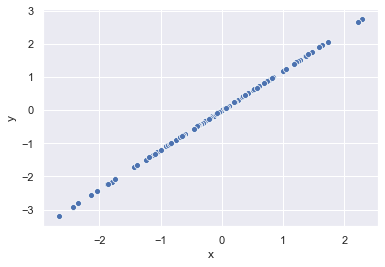

In [169]:
np.random.seed(2)
x = np.random.normal(size=100)
y = 1.2*x
df = pd.DataFrame({'x': x, 'y': y})
sns.scatterplot(x=x, y=y);
plt.xlabel('x')
plt.ylabel('y')

model_a = smf.ols(formula= 'y ~ x',data = df).fit()
model_b = smf.ols(formula= 'x ~ y',data= df).fit()
print(model_a.params)
print(model_b.params)

**(c) Generate an example in R with n = 100 observations in which the coefficient estimate for the regression of X onto Y is the same as the coefficient estimate for the regression of Y onto X**

Intercept   -1.804112e-16
y            1.000000e+00
dtype: float64
Intercept   -1.804112e-16
x            1.000000e+00
dtype: float64


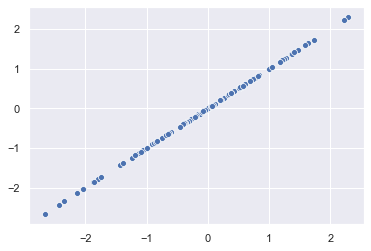

In [171]:
np.random.seed(2)
x= np.random.normal(size=100)
y= x
df = pd.DataFrame({'x':x,'y':y})
sns.scatterplot(x,y)

model_a = smf.ols(formula='x ~ y',data=df).fit()
model_b = smf.ols(formula= 'y ~ x ',data=df).fit()

print(model_a.params)
print(model_b.params)

# 13. In this exercise you will create some simulated data and will fit simple linear regression models to it. Make sure to use set.seed(1) prior to starting part (a) to ensure consistent results.

In [172]:
np.random.seed(1)

**(a) Using the rnorm() function, create a vector, x, containing 100 observations drawn from a N(0,1) distribution. This represents a feature, X**

In [175]:
x = np.random.normal(0,1,100)

**(b) Using the rnorm() function, create a vector, eps, containing 100 observations drawn from a N(0,0.25) distribution i.e. a normal distribution with mean zero and variance 0.25**

In [176]:
eps = np.random.normal(0,0.25,100)

**(c) Using x and eps, generate a vector y according to the model**

$Y =−1+0.5X+ε. (3.39)$

In [177]:
y = -1 + 0.5 * x + eps

**What is the length of the vector y? What are the values of β0 and β1 in this linear model?**

$β_0 = -1$

$β_1 = 0.5$

In [180]:
print("y lenght: {}".format(np.around(np.linalg.norm(y),4)))

y lenght: 11.4436


**(d) Create a scatterplot displaying the relationship between x and y. Comment on what you observe**

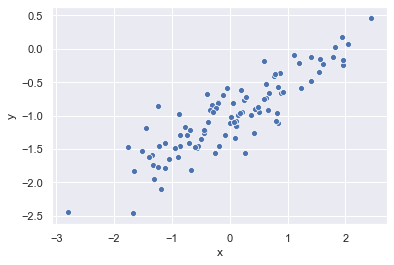

In [182]:
sns.scatterplot(x,y)
plt.xlabel('x')
plt.ylabel('y');

The above plot suggests a linear relationship between x and y with an intercept of roughly -2.5 and gradient of 0.5

**(e) Fit a least squares linear model to predict y using x. Comment on the model obtained. How do βˆ0 and βˆ1 compare to β0 and β1?**

In [242]:
model = smf.ols(formula='y ~ x',data = pd.DataFrame({'x':x,'y':y})).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     160.7
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.23e-22
Time:                        12:39:47   Log-Likelihood:                -54.638
No. Observations:                 100   AIC:                             113.3
Df Residuals:                      98   BIC:                             118.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0574      0.042    -24.987      0.0

The model estimates parameters close to the true values. The intercept is overestimated and the gradient is underestimated.

**(f) Display the least squares line on the scatterplot obtained in (d). Draw the population regression line on the plot, in a different color. Use the legend() command to create an appropriate legend.**

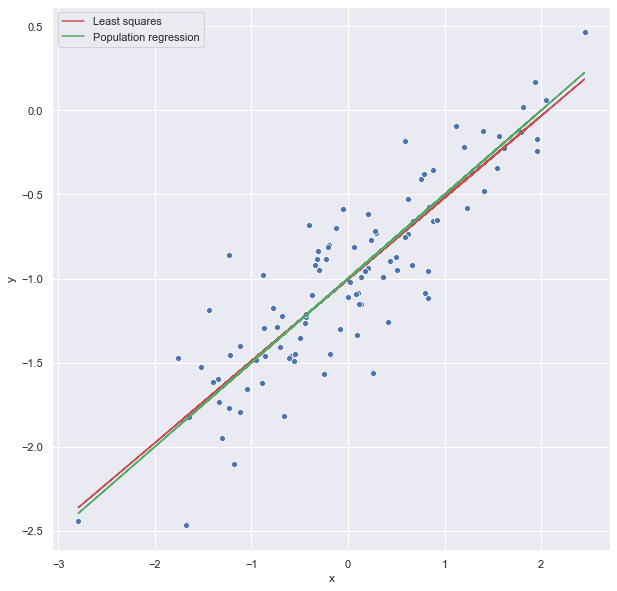

In [194]:
y_act  = -1+(0.5*x)
y_pred = model.predict()
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x,y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x,y_pred,color='r')
ax.plot(x,-1+(0.5*x),color='g')
ax.legend(['Least squares', 'Population regression']);

**(g) Now fit a polynomial regression model that predicts y using x and x2. Is there evidence that the quadratic term improves the model fit? Explain your answer.**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 04 May 2020   Prob (F-statistic):           6.48e-32
Time:                        12:16:41   Log-Likelihood:                -9.1716
No. Observations:                 100   AIC:                             24.34
Df Residuals:                      97   BIC:                             32.16
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0175      0.034    -30.157   

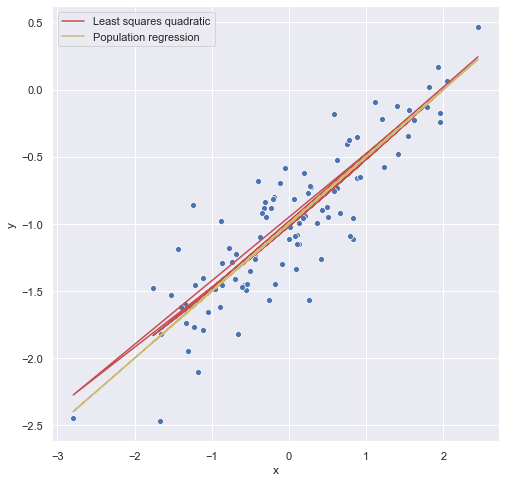

In [206]:
f = 'y ~ x + np.square(x)'
model = smf.ols(formula=f, data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())


# predict
y_pred = model.predict()
y_act  = -1+(0.5*x)

# plot
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x, y=y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x, model.predict(), color='r')
ax.plot(x, -1+(0.5*x), color='y')
ax.legend(['Least squares quadratic', 'Population regression']);

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     164.7
Date:                Mon, 04 May 2020   Prob (F-statistic):           6.48e-32
Time:                        12:25:43   Log-Likelihood:                -9.1716
No. Observations:                 100   AIC:                             24.34
Df Residuals:                      97   BIC:                             32.16
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0175      0.034    -30.157   

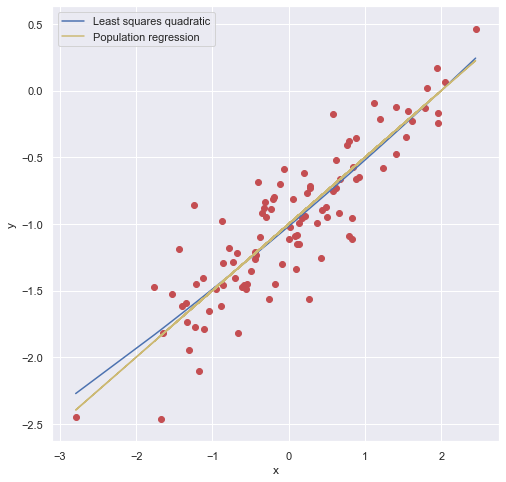

In [227]:
f = 'y ~ x + np.square(x)'
model = smf.ols(formula=f, data=pd.DataFrame({'x':x, 'y':y})).fit()
print(model.summary())

# predict
y_pred = model.predict()
y_act  = -1+(0.5*x)

# plot
plt.figure(figsize=(8,8))
ax1 = sns.lineplot(x, y=y_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y, color='r')
plt.plot(x, -1+(0.5*x), color='y')
ax1.legend(['Least squares quadratic', 'Population regression']);

The model selects a small coefficient for the quadratic variable and so the fit of our model is only slightly affected. The p-value > 0.05 for this variable suggests that it is not statistically significant in representing our data. The R-squared value is identical for both models suggesting that the quadratic model hasn't reduced the error of our model in fitting the data.

Overall the quadratic term does not seem to have improved our model.

**(h) Repeat (a)–(f) after modifying the data generation process in such a way that there is less noise in the data. The model (3.39) should remain the same. You can do this by decreasing the variance of the normal distribution used to generate the error term ε in (b). Describe your results.**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     138.0
Date:                Mon, 04 May 2020   Prob (F-statistic):           2.06e-20
Time:                        12:40:54   Log-Likelihood:                -49.877
No. Observations:                 100   AIC:                             103.8
Df Residuals:                      98   BIC:                             109.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0325      0.040    -25.620      0.0

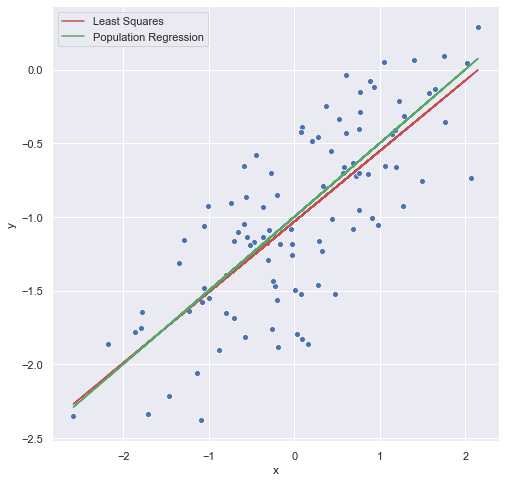

In [248]:
#a)
x = np.random.normal(0,1,100)
#b)
eps = np.random.normal(0,0.4,100)
#c)
y = -1 + 0.5 * x + eps

df = pd.DataFrame({'x':x,'y':y})

#e)
model2= smf.ols(formula='y ~ x',data= df).fit()
print(model2.summary())

#make predictions
y_pred = model2.predict()
y_act = -1 + 0.5*x

# plot
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x,y)
plt.xlabel('x')
plt.ylabel('y')
ax.plot(x,y_pred,color='r')
ax.plot(x,y_act,color='g')
ax.legend(['Least Squares','Population Regression'])

Increasing the variance in the dataset has increased the error in our model. This is reflected by a reduction in R-squared and an increased disparity between the least squares line and the true population regression line.

**(j) What are the confidence intervals for β0 and β1 based on the original data set, the noisier data set, and the less noisy data set? Comment on your results.**

In [249]:
# Noiser 
conf_interval_95 =  model2.conf_int(alpha=0.05)
conf_interval_95.rename(index=str, columns={0: "min.", 1: "max.",})


,min.,max.
Intercept,-1.112424,-0.952483
x,0.398209,0.560083


In [250]:
# Less Nosy
conf_interval_95_2 =  model.conf_int(alpha=0.05)
conf_interval_95_2.rename(index=str, columns={0: "min.", 1: "max.",})

,min.,max.
Intercept,-1.141351,-0.973397
x,0.430842,0.590759


Increasing the noise in varaince in our dataset appears to have increased the confidence interval in our model. Increased variance increases uncertainty.

# 14. This problem focuses on the collinearity problem.

**a) Perform the following commands in R:** 

set.seed(1)

$x1=runif(100)$

x2=0.5*x1+rnorm(100)/10

y=2+2*x1+0.3*x2+rnorm(100)

The last line corresponds to creating a linear model in which y is a function of x1 and x2. Write out the form of the linear model. What are the regression coefficients?

In [289]:
np.random.seed(1)
x1 = np.random.uniform(size=100)
x2 = 0.5 * x1 + np.random.randn(100) /10
y = 2 + 2*x1 + 0.3* x2 + np.random.randn(100)

Form of the linear model is:

$ŷ =β_0+β_1 x_1+β_2x_2+ɛ$

Where the coefficients are:

$β_0=2$

$β_1=2$

$β_2=0.3$

**(b) What is the correlation between x1 and x2? Create a scatterplot displaying the relationship between the variables.**

Correlation factor: 0.83906


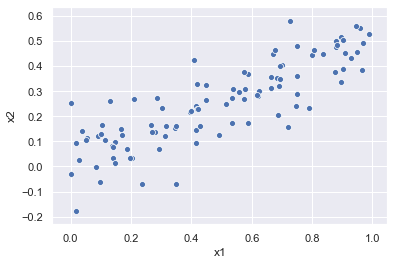

In [266]:
df = pd.DataFrame({'x1':x1,'x2':x2,'y':y})
sns.scatterplot(x1,x2,data=df)
plt.xlabel('x1')
plt.ylabel('x2')
print("Correlation factor: {}".format(np.around(np.corrcoef([x1,x2])[0][1],5)))

- There is correlation between x1 and x2 with coefficient 0.839. The plot suggests a linear relationship with a gradient of around 0.5 and high variance.

**c) Using this data, fit a least squares regression to predict y using x1 and x2. Describe the results obtained. What are βˆ0, βˆ1, and βˆ2? How do these relate to the true β0, β1, and β2? Can you reject the null hypothesis H0 : β1 = 0? How about the null hypothesis H0 : β2 = 0?**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     17.09
Date:                Mon, 04 May 2020   Prob (F-statistic):           4.40e-07
Time:                        14:54:04   Log-Likelihood:                -142.34
No. Observations:                 100   AIC:                             290.7
Df Residuals:                      97   BIC:                             298.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.0

Text(0.5, 0, 'x2')

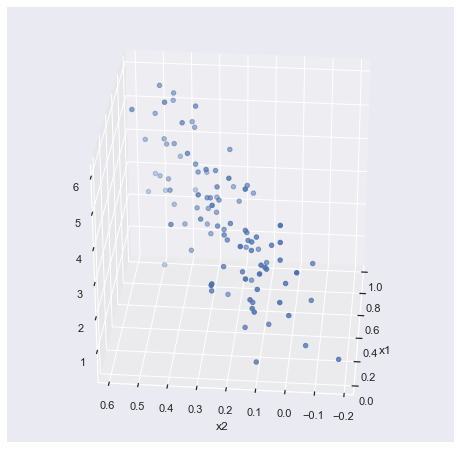

In [274]:
f = 'y ~ x1 + x2'

y,X = patsy.dmatrices(f,data=df,return_type='dataframe')
model  = sm.OLS(y,X).fit()
print(model.summary())

# plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x1'],df['x2'],df['y'])
ax.view_init(30,185)
plt.xlabel('x1')
plt.ylabel('x2')


In [275]:
model.pvalues.sort_values()

Intercept    8.532403e-19
x2           3.060418e-02
x1           2.712146e-01
dtype: float64

- The intercept β0̂  is estimated fairly accurately.

- β1̂  and β2̂  are not well estimated. It's almost as though our model has got these the wrong way around.
- we cannot reject the null hypothesis for β1̂  (p_value > 0.05)
- we can reject the null hypothesis for β2̂ 

**(d) Now fit a least squares regression to predict y using only x1. Comment on your results. Can you reject the null hypothesis H0 :β1 =0?**

In [281]:
f = 'y ~ x1'

model = smf.ols(formula=f,data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Mon, 04 May 2020   Prob (F-statistic):           6.68e-07
Time:                        15:02:27   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.0

In [282]:
model.pvalues

Intercept    2.942644e-19
x1           6.683125e-07
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.26
Date:                Mon, 04 May 2020   Prob (F-statistic):           6.68e-07
Time:                        15:21:46   Log-Likelihood:                -144.76
No. Observations:                 100   AIC:                             293.5
Df Residuals:                      98   BIC:                             298.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.0

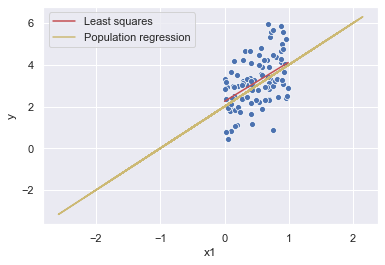

In [308]:
# plot
f = 'y ~ x1'
model = smf.ols(formula=f, data=df).fit()
print(model.summary())

df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
ax = sns.scatterplot(x='x1', y='y', data=df);
plt.xlabel('x1')
plt.ylabel('y')
ax.plot(df['x1'].sort_values(), model.predict(df['x1'].sot_values()), color='r')
ax.plot(x, 2+(2*x), color='y')
ax.legend(['Least squares', 'Population regression']);

- $β_0=2 $
- $β_1=2$
- $β_0̂ =2.2486$
- $β_1̂ =1.8770$

Using only x1 our model makes a much improved prediction of the x1 coefficient β1̂ .
The p-value now suggests we can reject the null hypothesis H0 :β1 =0

**(e) Now fit a least squares regression to predict y using only x2. Comment on your results. Can you reject the null hypothesis H0 :β1 =0?**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     32.87
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.09e-07
Time:                        15:20:40   Log-Likelihood:                -142.97
No. Observations:                 100   AIC:                             289.9
Df Residuals:                      98   BIC:                             295.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.0

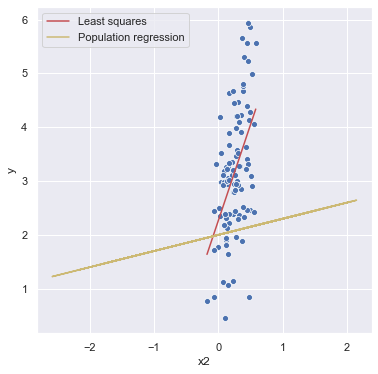

In [305]:
f = 'y ~ x2'

model = smf.ols(formula=f,data=df).fit()
print(model.summary())

y_pred = model.predict()
y_real = 2+0.3*x2
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})

plt.figure(figsize=(6,6))
ax = sns.scatterplot(x='x2', y='y', data=df);
plt.xlabel('x2')
plt.ylabel('y')
ax.plot(df['x2'].sort_values(), model.predict(df['x2'].sort_values()), color='r')
ax.plot(x, 2+(0.3*x), color='y')
ax.legend(['Least squares', 'Population regression']);

- $β_0=2 $
- $β_2=0.3$
- $β_0̂ =2.2655$
- $β_2̂ =3.5613$

Our model overestimates the coefficient. The p-value suggests we can reject the null hypothesis H0 :β2 =0.

Ground truth

- β0=2
- β1=2
- β2=0.3

c) y ~ x1 + x2

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1893      0.199     11.021      0.000       1.795       2.584

x1             0.7046      0.637      1.107      0.271      -0.559       1.968

x2             2.5024      1.140      2.194      0.031       0.239       4.766


d) y ~ x1

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2486      0.201     11.209      0.000       1.850       2.647
x1             1.8770      0.353      5.316      0.000       1.176       2.578

d) y ~ x2

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2655      0.187     12.145      0.000       1.895       2.636
x2             3.5613      0.621      5.733      0.000       2.329       4.794

- β1 

   - result c) suggests probability < 0.271 that the null hypothesis H0:β1=0 is true
    
   - result d) suggests probability < 0.000 that the null hypothesis H0:β1=0 is true
 
- β2
    
    - result c) suggests probability < 0.031 that the null hypothesis H0:β2=0 is true
    - result e) suggests probability < 0.000 that the null hypothesis H0:β2=0 is true
    
Yes. We get contradictory results for the p-value associated with β1, which in results c would cause us to accept the null hypothesis and in d) we would reject it.

This contradiction can be explained by the collinearity of x1 and x2 which causes an increased standard error for all βj when our model incorporates both features, which in turn increases the p-values and causes us to incorrectly accept the null hypothesis H0:β1=0 when our model uses both features

**(g) Now suppose we obtain one additional observation, which was unfortunately mismeasured.**

- x1=c(x1, 0.1) 

- x2=c(x2, 0.8)

- y=c(y,6)

**Re-fit the linear models from (c) to (e) using this new data. What effect does this new observation have on the each of the models? In each model, is this observation an outlier? A high-leverage point? Both? Explain your answers.**

In [337]:
#df = df.append({'x1':0.1,'x2':0.8,'y':6},ignore_index=True)
#df = df.drop(df.index[[101]])
df

model_a = smf.ols(formula='y ~ x1 + x2',data=df).fit()
model_b = smf.ols(formula= 'y ~ x1',data=df).fit()
model_c = smf.ols(formula='y ~ x2',data=df).fit()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     19.92
Date:                Mon, 04 May 2020   Prob (F-statistic):           5.51e-08
Time:                        15:56:47   Log-Likelihood:                -144.15
No. Observations:                 101   AIC:                             294.3
Df Residuals:                      98   BIC:                             302.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1996      0.199     11.041      0.0

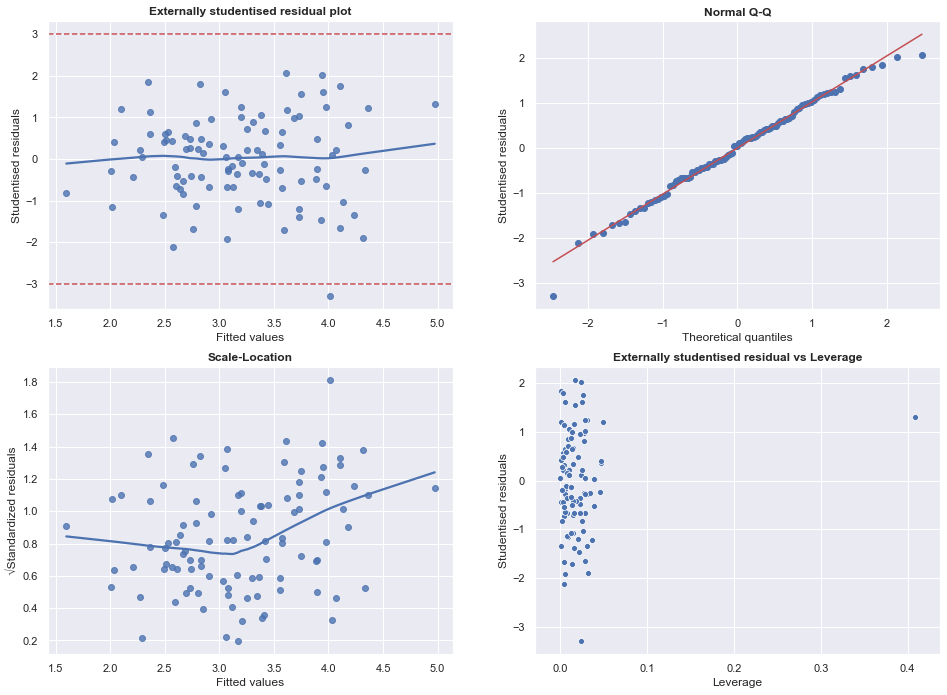

In [348]:
# model a
#y_act =  2 + 2*x1 + 0.3* x2

xc = pd.concat([df['x1'],df['x2']],axis=1)
y_pred = model_a.predict(xc)
print(model_a.summary())

lm_plot(lm_stats(xc,df['y'],y_pred))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     21.89
Date:                Mon, 04 May 2020   Prob (F-statistic):           9.15e-06
Time:                        15:59:05   Log-Likelihood:                -151.28
No. Observations:                 101   AIC:                             306.6
Df Residuals:                      99   BIC:                             311.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3583      0.208     11.331      0.0

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


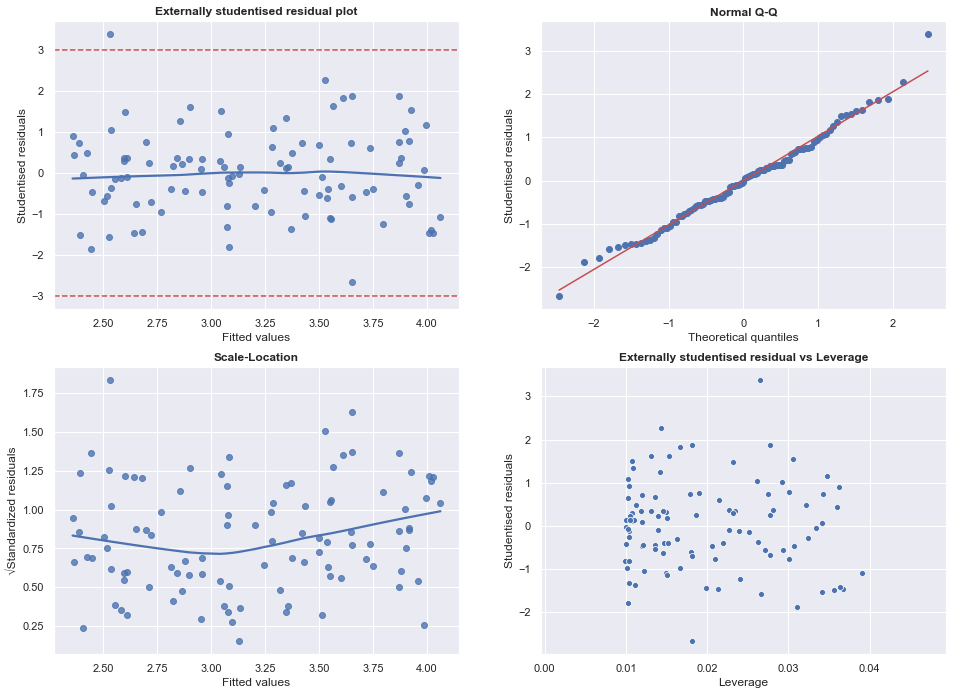

In [351]:
# model b


y_pred_b = model_b.predict(df['x1'])
print(model_b.summary())

lm_plot(lm_stats(sm.add_constant(df['x1']),df['y'],y_pred_b))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     39.99
Date:                Mon, 04 May 2020   Prob (F-statistic):           7.41e-09
Time:                        15:59:59   Log-Likelihood:                -144.24
No. Observations:                 101   AIC:                             292.5
Df Residuals:                      99   BIC:                             297.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2331      0.182     12.271      0.0

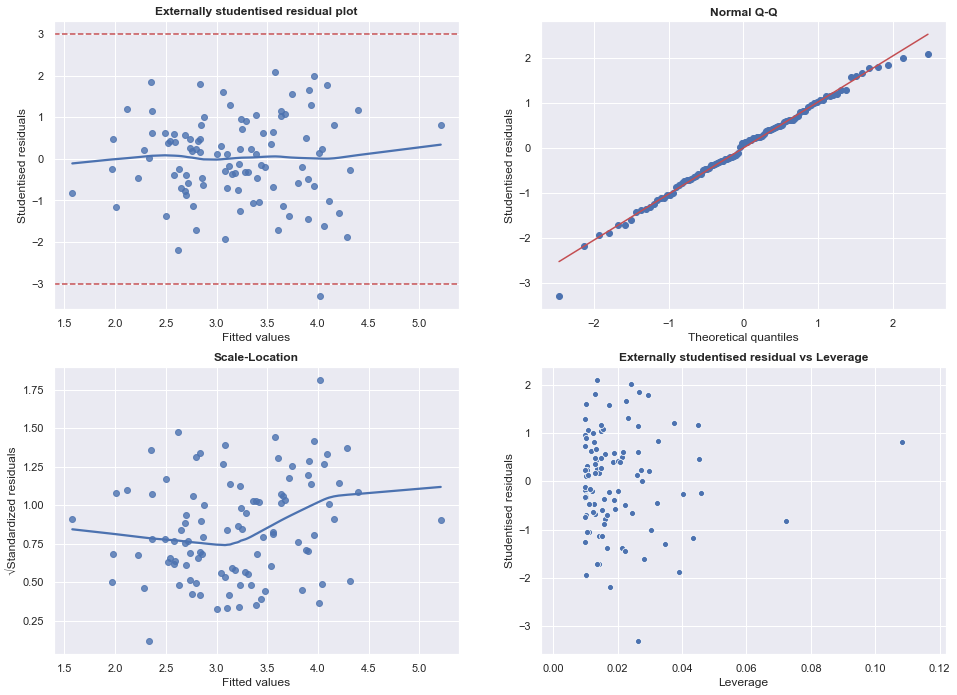

In [352]:
# model c

y_pred_c = model_c.predict(df['x2'])
print(model_c.summary())

lm_plot(lm_stats(sm.add_constant(df['x2']),df['y'],y_pred_c))

**Comments:**

- The addition of this anomaly has increased model a's p-value for β1̂ , suggesting even more strongly the false acceptance of the null hpyothesis.

- When considered seperately the estimates for β1̂  and β2̂  are worsened by introducing this anomaly.

- model_c : the anomaly is almost an outlier, it is very high leverage
- model_d : the anomaly is an outlier but not particularly high leverage
- model_e : the anomaly is not an outlier but is fairly high leverage

The anomaly has a detrimental effect on model_C, as a high levarage outlier. It has a less detrimental effect on model d and e where it is either low leverage or not an outlier.

This suggests that models with collinear features are less robust in context of anomalous observations.

# 15. This problem involves the Boston data set, which we saw in the lab for this chapter. We will now try to predict per capita crime rate using the other variables in this data set. In other words, per capita crime rate is the response, and the other variables are the predictors.¶

**(a) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions**


In [367]:
boston = load_boston()
boston = pd.DataFrame(data=boston.data,columns=boston.feature_names)
assert boston.isnull().sum().sum() == 0

models_a = [smf.ols(formula='CRIM ~ {}'.format(f), data=boston).fit()
            for f in boston.columns[1:]]

for model in models_a:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.4537,0.4172,10.6747,0.0,3.6340,5.2734
ZN,-0.0739,0.0161,-4.5938,0.0,-0.1056,-0.0423


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.0637,0.6672,-3.0930,0.0021,-3.3746,-0.7529
INDUS,0.5098,0.0510,9.9908,0.0000,0.4095,0.6100


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7444,0.3961,9.4530,0.0000,2.9662,4.5227
CHAS,-1.8928,1.5061,-1.2567,0.2094,-4.8518,1.0663


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-13.7199,1.6995,-8.073,0.0,-17.0588,-10.3809
NOX,31.2485,2.9992,10.419,0.0,25.3561,37.1410


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,20.4818,3.3645,6.0877,0.0,13.8717,27.0919
RM,-2.6841,0.5320,-5.0448,0.0,-3.7293,-1.6388


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.7779,0.9440,-4.0021,0.0001,-5.6325,-1.9233
AGE,0.1078,0.0127,8.4628,0.0000,0.0828,0.1328


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,9.4993,0.7304,13.0056,0.0,8.0643,10.9343
DIS,-1.5509,0.1683,-9.2135,0.0,-1.8816,-1.2202


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.2872,0.4435,-5.1573,0.0,-3.1584,-1.4159
RAD,0.6179,0.0343,17.9982,0.0,0.5505,0.6854


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-8.5284,0.8158,-10.4539,0.0,-10.1312,-6.9256
TAX,0.0297,0.0018,16.0994,0.0,0.0261,0.0334


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-17.6469,3.1473,-5.6071,0.0,-23.8303,-11.4635
PTRATIO,1.1520,0.1694,6.8014,0.0,0.8192,1.4847


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,16.5535,1.4259,11.6092,0.0,13.7521,19.3550
B,-0.0363,0.0039,-9.3670,0.0,-0.0439,-0.0287


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.3305,0.6938,-4.8007,0.0,-4.6936,-1.9675
LSTAT,0.5488,0.0478,11.4907,0.0,0.4550,0.6426


In [377]:
# In which of the models is there a statistically significant association between the predictor and the response?

display(HTML('<h3>p < 0.05</h3>'))
for model in models_a:
    if model.pvalues[1] < 0.05:
        print(model.params[1:].index[0])
        
display(HTML('<h3>p > 0.05 </h3>'))
for model in models_a:
    if model.pvalues[1] > 0.05:
        print(model.params[1:].index[0])

ZN
INDUS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


CHAS


0
4
8


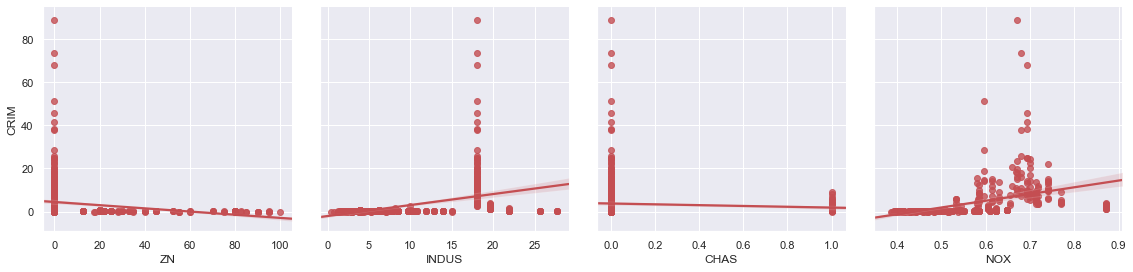

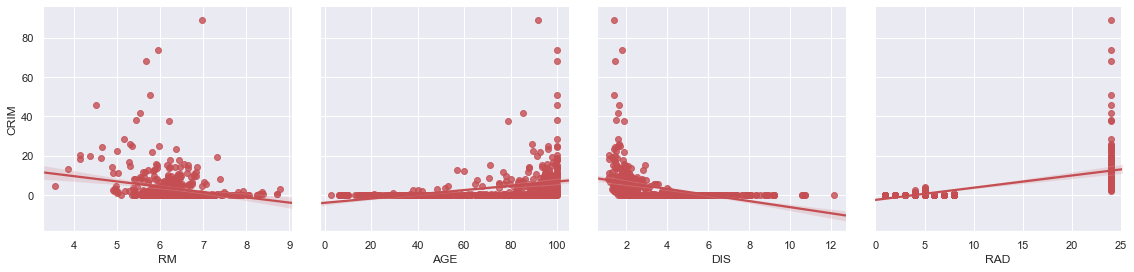

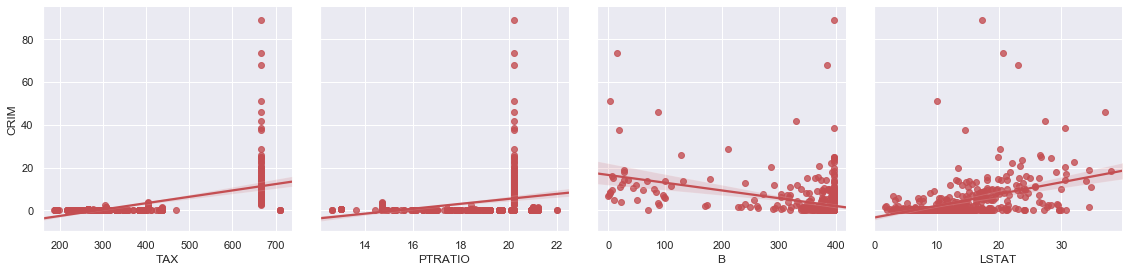

In [382]:
def plot_grid(df,response,cols):
    variables = df.columns.drop(response)
    for i in range(0, len(variables),4):
        print(i)
        g = sns.PairGrid(data=df,y_vars=response,x_vars = variables[i:i+cols],height=4)
        g.map(sns.regplot,color='r')
    return

plot_grid(boston, 'CRIM', 4)
    
    

**(b) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?**

In [394]:
response = 'CRIM'
predictors = boston.columns.drop(['CRIM'])
f = '{} ~ {}'.format(response,'+'.join(predictors))

model = smf.ols(formula=f,data=boston).fit()
print(model.summary())
print(model.pvalues[model.pvalues<0.05].sort_values())

                            OLS Regression Results                            
Dep. Variable:                   CRIM   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     32.55
Date:                Mon, 04 May 2020   Prob (F-statistic):           4.84e-55
Time:                        17:52:28   Log-Likelihood:                -1658.8
No. Observations:                 506   AIC:                             3344.
Df Residuals:                     493   BIC:                             3398.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9967      6.979      1.432      0.1

**(c) How do your results from (a) compare to your results from (b)? Create a plot displaying the univariate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.**

Multivariate regression found 4 of 12 predictors to be significnat where univariate regression found 11 of 12 significant. Multivariate regression seems to find significanlty less predictors to be significant

,index,univariate,multivariate_params
0,ZN,-0.073935,0.036405
1,INDUS,0.509776,-0.069435
2,CHAS,-1.892777,-1.311667
3,NOX,31.248531,-6.928836
4,RM,-2.684051,-0.334794
5,AGE,0.107786,0.001343
6,DIS,-1.550902,-0.708934
7,RAD,0.617911,0.538916
8,TAX,0.029742,-0.001356
9,PTRATIO,1.151983,-0.083383


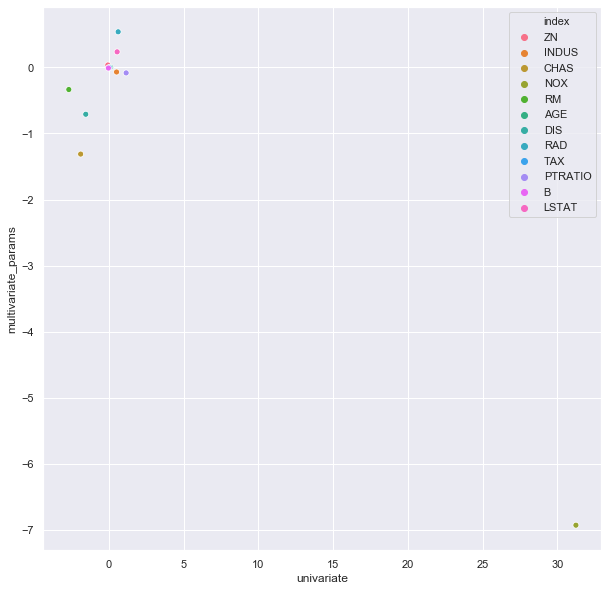

In [426]:
#get coefficients 
univariate_par = pd.concat([m.params[1:] for m in models_a])
multivariate_params = model.params[1:]

#df2 = pd.DataFrame({'univariate':univariate_par,'multivariate_params':multivariate_params}).reset_index()
display(df2)
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='univariate', y='multivariate_params',hue='index',legend="full", data=df2,);

(d) Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form

$ Y=β_0+β_1 X+β_2 X^2+ β_3 X^3+ε$

In [444]:
model_c = [smf.ols(formula='CRIM ~ {0} + np.power({0}, 2) + np.power({0}, 3)'.format(i),data=boston).fit() 
           for i in boston.columns[1:]  ]

for model in model_c:
    display(pd.DataFrame({'coef':model.params,
                         'std_err': model.bse,
                         't': model.params/model.bse,
                         'P>t':model.pvalues,
                         '[0.025': model.conf_int(alpha=0.05)[0],
                         '0,975]': model.conf_int(alpha=0.05)[1]}))

,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,4.846050,0.432985,11.192199,4.113000e-26,3.995365,5.696735
ZN,-0.332188,0.109808,-3.025171,2.612296e-03,-0.547929,-0.116448
"np.power(ZN, 2)",0.006483,0.003861,1.679122,9.375050e-02,-0.001103,0.014068
"np.power(ZN, 3)",-0.000038,0.000031,-1.203012,2.295386e-01,-0.000099,0.000024


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,3.662568,1.573983,2.326942,2.036526e-02,0.570162,6.754975
INDUS,-1.965213,0.481990,-4.077289,5.297064e-05,-2.912179,-1.018247
"np.power(INDUS, 2)",0.251937,0.039322,6.407011,3.420187e-10,0.174681,0.329194
"np.power(INDUS, 3)",-0.006976,0.000957,-7.292049,1.196405e-12,-0.008856,-0.005096


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,3.744447,0.396111,9.453021,1.239505e-19,2.966214,4.522679
CHAS,-0.630926,0.502038,-1.256727,2.094345e-01,-1.617272,0.355420
"np.power(CHAS, 2)",-0.630926,0.502038,-1.256727,2.094345e-01,-1.617272,0.355420
"np.power(CHAS, 3)",-0.630926,0.502038,-1.256727,2.094345e-01,-1.617272,0.355420


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,233.086591,33.643101,6.928214,1.311939e-11,166.987961,299.185220
NOX,-1279.371252,170.397473,-7.508159,2.758372e-13,-1614.151311,-944.591192
"np.power(NOX, 2)",2248.544053,279.899273,8.033404,6.811300e-15,1698.625715,2798.462391
"np.power(NOX, 3)",-1245.702874,149.281640,-8.344649,6.961110e-16,-1538.996638,-952.409110


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,112.624596,64.517236,1.745651,0.081483,-14.132472,239.381664
RM,-39.150136,31.311492,-1.250344,0.211756,-100.667850,22.367577
"np.power(RM, 2)",4.550896,5.009862,0.908388,0.364109,-5.291984,14.393775
"np.power(RM, 3)",-0.174477,0.263747,-0.661531,0.508575,-0.692661,0.343707


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,-2.548763,2.769140,-0.920417,0.357797,-7.989296,2.891769
AGE,0.273653,0.186380,1.468257,0.142661,-0.092527,0.639833
"np.power(AGE, 2)",-0.007230,0.003637,-1.987793,0.047377,-0.014375,-0.000084
"np.power(AGE, 3)",0.000057,0.000021,2.723727,0.006680,0.000016,0.000099


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,30.047612,2.445870,12.285042,1.633088e-30,25.242209,34.853014
DIS,-15.554353,1.735967,-8.960049,6.374792e-18,-18.965010,-12.143697
"np.power(DIS, 2)",2.452072,0.346419,7.078333,4.941214e-12,1.771462,3.132683
"np.power(DIS, 3)",-0.118599,0.020400,-5.813544,1.088832e-08,-0.158679,-0.078518


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,-0.605545,2.050108,-0.295372,0.767832,-4.633393,3.422304
RAD,0.512736,1.043597,0.491316,0.623418,-1.537619,2.563091
"np.power(RAD, 2)",-0.075177,0.148543,-0.506098,0.613010,-0.367020,0.216665
"np.power(RAD, 3)",0.003209,0.004564,0.703109,0.482314,-0.005758,0.012176


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,1.918358e+01,1.179555e+01,1.626341,0.104505,-3.991139e+00,4.235830e+01
TAX,-1.533096e-01,9.567806e-02,-1.602349,0.109708,-3.412884e-01,3.466915e-02
"np.power(TAX, 2)",3.608266e-04,2.425463e-04,1.487661,0.137468,-1.157042e-04,8.373575e-04
"np.power(TAX, 3)",-2.203715e-07,1.888705e-07,-1.166786,0.243851,-5.914456e-07,1.507025e-07


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,477.184046,156.794978,3.043363,0.002462,169.128821,785.239271
PTRATIO,-82.360538,27.643942,-2.979334,0.003029,-136.672615,-28.048461
"np.power(PTRATIO, 2)",4.635347,1.608321,2.882103,0.004120,1.475477,7.795217
"np.power(PTRATIO, 3)",-0.084760,0.030897,-2.743275,0.006301,-0.145465,-0.024056


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,1.826370e+01,2.304903e+00,7.923847,1.497097e-14,13.735255,2.279215e+01
B,-8.355805e-02,5.632751e-02,-1.483432,1.385871e-01,-0.194225,2.710866e-02
"np.power(B, 2)",2.137404e-04,2.984193e-04,0.716242,4.741751e-01,-0.000373,8.000450e-04
"np.power(B, 3)",-2.652453e-07,4.364264e-07,-0.607767,5.436172e-01,-0.000001,5.922019e-07


,coef,std_err,t,P>t,[0.025,"0,975]"
Intercept,1.200966,2.028645,0.592004,0.554115,-2.784715,5.186646
LSTAT,-0.449066,0.464891,-0.965959,0.334530,-1.362438,0.464306
"np.power(LSTAT, 2)",0.055779,0.030116,1.852176,0.064587,-0.003389,0.114948
"np.power(LSTAT, 3)",-0.000857,0.000565,-1.517022,0.129891,-0.001968,0.000253


In [449]:
# In which of the models is there a statistically significant association between the predictor and the response?

display(HTML('<h3> PValues <0.05 </h3>'))

results = pd.concat([model.pvalues[model.pvalues<0.05] for model in model_c])
display(results)

Intercept               4.113000e-26
ZN                      2.612296e-03
Intercept               2.036526e-02
INDUS                   5.297064e-05
np.power(INDUS, 2)      3.420187e-10
np.power(INDUS, 3)      1.196405e-12
Intercept               1.239505e-19
Intercept               1.311939e-11
NOX                     2.758372e-13
np.power(NOX, 2)        6.811300e-15
np.power(NOX, 3)        6.961110e-16
np.power(AGE, 2)        4.737733e-02
np.power(AGE, 3)        6.679915e-03
Intercept               1.633088e-30
DIS                     6.374792e-18
np.power(DIS, 2)        4.941214e-12
np.power(DIS, 3)        1.088832e-08
Intercept               2.462124e-03
PTRATIO                 3.028663e-03
np.power(PTRATIO, 2)    4.119552e-03
np.power(PTRATIO, 3)    6.300514e-03
Intercept               1.497097e-14
dtype: float64

In [1]:
x= [1,2]


In [2]:
std(x)

NameError: name 'std' is not defined